## Avaliação Total da Disciplina
### Solução para empresa de logística que opera uma frota de robôs de entrega autônomos

* Contexto:
  * Imagine que você está trabalhando em uma empresa de logística que opera uma frota de robôs de entrega autônomos. Sua tarefa é implementar um algoritmo de aprendizado por reforço para otimizar a entrega de pacotes em um ambiente simulado. Os robôs têm a capacidade de se mover em um ambiente em grade 2D e devem aprender a tomar decisões sobre para onde se mover para entregar pacotes de forma eficiente.

* Objetivo:
  * O objetivo do desafio é implementar um agente de aprendizado por reforço usando ténicas como por exemplo Q-Table, equação de Bellman, ε-greedy e etc, para maximizar o retorno cumulativo ao entregar pacotes no menor tempo possível, considerando um "living penalty" para incentivar o agente a ser eficiente.


* Critérios de Avaliação:
  1.	Implementação correta do ambiente, MDP e Q-Table.
  2.	Implementação do algoritmo de aprendizado por reforço (Q-Learning ou similar).
  3.	Introdução e configuração adequada do "living penalty".
  4.	Eficiência do agente na entrega de pacotes.
  5.	Documentação clara e código bem comentado em Python.

## 1 - Modelagem do ambiente

  * Crie um ambiente 2D simulado, onde o agente pode se mover em um grid. Considere que o ambiente tem obstáculos e pontos de entrega de pacotes.

In [1]:
# @title Importando libs
import time
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
# Criando um ambiente simulado
# Definir a classe Environment
class Environment:
    def __init__(self, grid_size, obstacles, delivery_points):
        # Inicialização da classe com três parâmetros: tamanho da grade, obstáculos e pontos de entrega
        self.grid_size = grid_size  # Tamanho da grade, no nosso exemplo será (10, 10)
        self.grid = np.zeros(grid_size, dtype=int)  # Inicializa uma grade com zeros
        self.obstacles = obstacles  # Lista de coordenadas dos obstáculos
        self.delivery_points = delivery_points  # Lista de coordenadas dos pontos de entrega
        self.agent_position = (0, 0)  # Define a posição inicial do agente como (0, 0)
        self.done = False  # Variável para controlar o término do ambiente

    def reset(self):
        # Reinicializa o ambiente para um novo episódio
        self.grid = np.zeros(self.grid_size, dtype=int)  # Zera a grade
        self.agent_position = (0, 0)  # Define a posição inicial do agente

        # Marca os obstáculos na grade com -1
        for obs in self.obstacles:
            self.grid[obs] = -1

        # Marca os pontos de entrega na grade com 1
        for delivery_point in self.delivery_points:
            self.grid[delivery_point] = 1

    def is_valid_move(self, position):
        # Verifica se uma posição é válida (dentro dos limites da grade e não é um obstáculo)
        x, y = position
        return 0 <= x < self.grid_size[0] and 0 <= y < self.grid_size[1] and self.grid[position] != -1

    def take_action(self, action):
        # Realiza uma ação (mover o agente) com base na ação fornecida
        if action == 'up':
            new_position = (self.agent_position[0] - 1, self.agent_position[1])
        elif action == 'down':
            new_position = (self.agent_position[0] + 1, self.agent_position[1])
        elif action == 'left':
            new_position = (self.agent_position[0], self.agent_position[1] - 1)
        elif action == 'right':
            new_position = (self.agent_position[0], self.agent_position[1] + 1)
        else:
            raise ValueError("Ação inválida")  # Levanta um erro se a ação não for reconhecida

        if self.is_valid_move(new_position):
            self.agent_position = new_position  # Move o agente para a nova posição

        if self.agent_position == self.delivery_points:
            self.done = True  # Marca o ambiente como concluído se o agente estiver em um ponto de entrega

    def get_states(self):
        # Retorna uma lista de todas as posições possíveis na grade
        states = []
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                states.append((i, j))
        return states

    def get_actions(self):
        # Retorna uma lista das ações possíveis (mover para cima, baixo, esquerda ou direita)
        return ['up', 'down', 'left', 'right']

    def get_state(self):
        # Retorna a posição atual do agente
        return self.agent_position

    def is_at_delivery_point(self):
        # Verifica se o agente está em um ponto de entrega
        return self.grid[self.agent_position] == 1

    def get_reward(self):
        # Retorna a recompensa com base na posição do agente
        if self.is_at_delivery_point():
            return 10  # Recompensa positiva por entregar um pacote
        else:
            return -1  # Penalização (living penalty) por cada passo

    def is_done(self):
        # Verifica se o ambiente foi concluído (todos os pontos de entrega foram coletados)
        return all([self.grid[position] == 0 for position in self.delivery_points])

    def print_environment(self):
        # Imprime uma representação gráfica do ambiente no console
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if (i, j) == self.agent_position:
                    print("A", end=' ')  # Representa a posição do agente
                elif self.grid[i, j] == -1:
                    print("X", end=' ')  # Representa um obstáculo
                elif self.grid[i, j] == 1:
                    print("D", end=' ')  # Representa um ponto de entrega
                else:
                    print("--", end=' ')  # Representa um espaço vazio
            print()

In [3]:
# Exemplo de uso:
grid_size = (10, 10) # Definição do Grid
# Obstáculos no grid
obstacles = [(0,5), (1,1), (1,7), (2,4), (2,0), (3,8), (3,3), (4,3), (4,5), (5,1), (5,6), (6,0), (6,5), (7,4), (7,6), (8,2), (8,9), (9,6)]
delivery_points = [(9,4), (9,9)] # Pontos de entrega
env = Environment(grid_size, obstacles, delivery_points) # Criação do ambiente
env.reset() # Reset do ambiente
env.print_environment() # Visualização do ambiente completo

A -- -- -- -- X -- -- -- -- 
-- X -- -- -- -- -- X -- -- 
X -- -- -- X -- -- -- -- -- 
-- -- -- X -- -- -- -- X -- 
-- -- -- X -- X -- -- -- -- 
-- X -- -- -- -- X -- -- -- 
X -- -- -- -- X -- -- -- -- 
-- -- -- -- X -- X -- -- -- 
-- -- X -- -- -- -- -- -- X 
-- -- -- -- D -- X -- -- D 


#### Considerações
Aqui criamos a classe `Environment` que representa o ambiente 2D com obstáculos e pontos de entrega de pacotes. O método `reset` é usado para reiniciar o ambiente, o método `take_action` permite que o agente tome ações como ('up', 'down', 'left', 'right'), e outros métodos fornecem informações sobre o estado, recompensa, e se o ambiente foi concluído.

## 2 - Definição do MDP

  * Modele o problema como um MDP, definindo os estados, as ações, as recompensas, a função de transição e o fator de desconto.

In [4]:
# Definir a classe MDP
class MDP:
    def __init__(self, environment, gamma=0.9):
        # Inicialização da classe com um ambiente e um fator de desconto (gamma)
        self.environment = environment  # O ambiente em que o MDP opera
        self.gamma = gamma  # Fator de desconto para recompensas futuras

    def get_states(self):
        # Retorna uma lista de todos os estados possíveis no MDP, que corresponde às posições na grade do ambiente
        return [(i, j) for i in range(self.environment.grid_size[0]) for j in range(self.environment.grid_size[1])]

    def get_actions(self):
        # Retorna uma lista das ações possíveis no MDP, que são as mesmas ações disponíveis no ambiente
        return ['up', 'down', 'left', 'right']

    def transition_probabilities(self, state, action):
        # Calcula as probabilidades de transição de um estado para os estados subsequentes, dado uma ação
        if not self.environment.is_valid_move(state):
            return []  # Se o estado não for válido, não há transições possíveis

        new_environment = self.environment.copy()  # Cria uma cópia do ambiente para simular a transição
        new_environment.take_action(action)  # Simula a ação no novo ambiente
        new_state = new_environment.get_state()  # Obtém o novo estado após a ação

        if new_environment.is_done():
            return [(new_state, 1.0)]  # Se o ambiente estiver concluído, a probabilidade de permanecer no novo estado é 1.0

        return [(new_state, 1.0)]  # Se o ambiente não estiver concluído, a probabilidade de transição é 1.0 para o novo estado

    def get_reward(self, state):
        # Retorna a recompensa associada a um estado, que é obtida do ambiente
        return self.environment.get_reward()

    def is_terminal(self, state):
        # Verifica se um estado é um estado terminal, ou seja, se o ambiente está concluído
        return self.environment.is_done()


In [5]:
num_rows, num_cols = env.grid_size # Pegando a quantidade de valor final do eixo X e Y do grid
V = np.zeros((num_rows, num_cols)) # Criando um grid com zeros

print(num_rows) # Vendo o valor do número de linhas
print(num_cols) # Vendo o valor do número de colunas
V # vendo o grid de zeros

10
10


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [6]:
# Definição do gamma
gamma = 0.9
gamma

0.9

In [7]:
# Função para calcular o valor de um estado usando a fórmula do MDP
def calculate_value(state, action):
    # Recebe um estado e uma ação como entrada e calcula o valor do estado após tomar a ação

    row, col = state  # Obtém as coordenadas (linha, coluna) do estado
    if env.grid[row, col] == 1:  # Se o estado for um objetivo (ponto de entrega)
        return 1
    if env.grid[row, col] == -1:  # Se o estado for um obstáculo
        return 0

    next_state = (row, col)  # Inicializa o próximo estado como o estado atual
    if action == 'up':
        next_state = (max(row - 1, 0), col)  # Calcula o próximo estado se a ação for 'up'
    elif action == 'down':
        next_state = (min(row + 1, num_rows - 1), col)  # Calcula o próximo estado se a ação for 'down'
    elif action == 'left':
        next_state = (row, max(col - 1, 0))  # Calcula o próximo estado se a ação for 'left'
    elif action == 'right':
        next_state = (row, min(col + 1, num_cols - 1))  # Calcula o próximo estado se a ação for 'right'

    # Calcula o valor do estado com base na fórmula do MDP
    return gamma * (0.8 * V[next_state[0], next_state[1]] + 0.2 * V[row, col])


Iteração 0:
Valores de cada estado:
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.72 0.   0.   0.   1.  ]]
Delta (Maior diferença entre os valores): 1.0



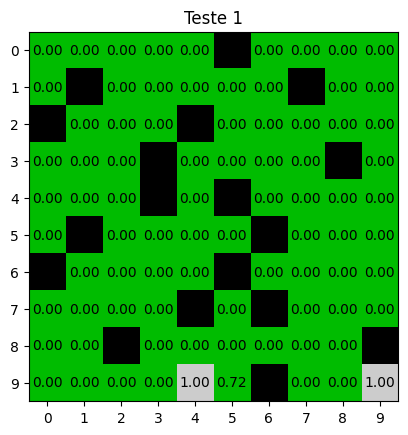

Iteração 1:
Valores de cada estado:
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.72 0.52 0.37 0.27 0.19 0.  ]
 [0.   0.   0.   0.72 1.   0.85 0.   0.19 0.72 1.  ]]
Delta (Maior diferença entre os valores): 0.7200000000000001



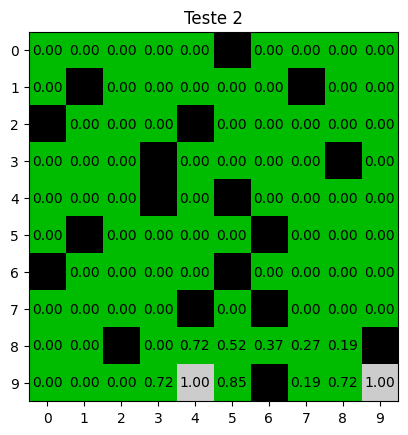

Iteração 2:
Valores de cada estado:
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.37 0.   0.19 0.14 0.1 ]
 [0.   0.   0.   0.52 0.85 0.71 0.57 0.46 0.55 0.  ]
 [0.   0.   0.52 0.85 1.   0.87 0.   0.55 0.85 1.  ]]
Delta (Maior diferença entre os valores): 0.5184000000000001



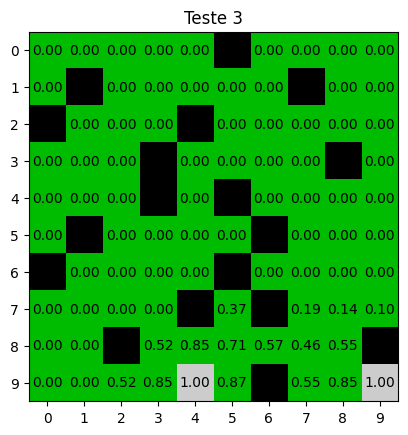

Iteração 3:
Valores de cada estado:
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.14 0.1  0.07]
 [0.   0.   0.   0.37 0.   0.57 0.   0.37 0.42 0.32]
 [0.   0.   0.   0.71 0.87 0.76 0.65 0.55 0.71 0.  ]
 [0.   0.37 0.71 0.87 1.   0.88 0.   0.71 0.87 1.  ]]
Delta (Maior diferença entre os valores): 0.3732480000000001



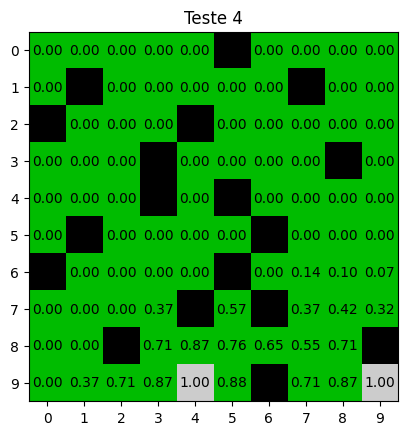

Iteração 4:
Valores de cada estado:
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.1  0.07 0.05]
 [0.   0.   0.   0.27 0.19 0.   0.1  0.29 0.32 0.25]
 [0.   0.   0.27 0.57 0.   0.65 0.   0.46 0.59 0.48]
 [0.   0.27 0.   0.76 0.88 0.77 0.67 0.61 0.76 0.  ]
 [0.27 0.57 0.76 0.88 1.   0.88 0.   0.76 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.26873856000000007



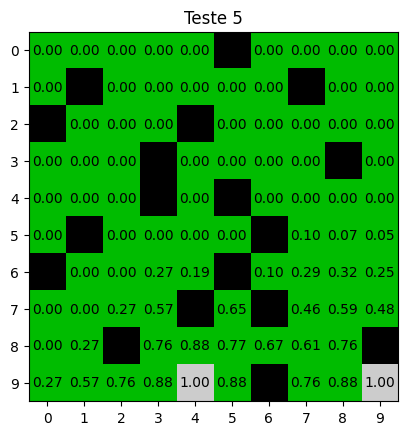

Iteração 5:
Valores de cada estado:
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.07 0.05 0.04]
 [0.   0.   0.   0.19 0.14 0.1  0.   0.23 0.25 0.19]
 [0.   0.   0.19 0.46 0.37 0.   0.23 0.38 0.48 0.39]
 [0.   0.19 0.46 0.65 0.   0.67 0.   0.52 0.65 0.56]
 [0.19 0.46 0.   0.77 0.88 0.77 0.68 0.65 0.77 0.  ]
 [0.46 0.65 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.1934917632000001



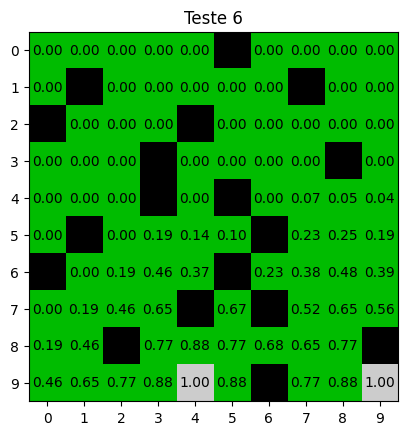

Iteração 6:
Valores de cada estado:
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.05 0.   0.03]
 [0.   0.   0.   0.   0.1  0.   0.05 0.18 0.19 0.14]
 [0.   0.   0.14 0.37 0.29 0.23 0.   0.32 0.39 0.32]
 [0.   0.14 0.37 0.55 0.46 0.   0.32 0.45 0.56 0.47]
 [0.14 0.37 0.55 0.67 0.   0.68 0.   0.57 0.67 0.58]
 [0.37 0.55 0.   0.77 0.88 0.77 0.68 0.67 0.77 0.  ]
 [0.55 0.67 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.17414258688000012



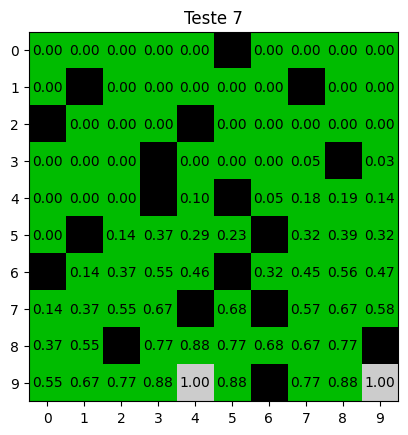

Iteração 7:
Valores de cada estado:
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.04 0.03 0.02]
 [0.   0.   0.   0.   0.07 0.05 0.04 0.14 0.   0.11]
 [0.   0.   0.1  0.   0.23 0.   0.14 0.26 0.32 0.25]
 [0.   0.   0.29 0.46 0.38 0.32 0.   0.38 0.47 0.4 ]
 [0.   0.29 0.46 0.58 0.5  0.   0.38 0.49 0.58 0.5 ]
 [0.29 0.46 0.58 0.68 0.   0.68 0.   0.58 0.68 0.59]
 [0.46 0.58 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.58 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.15045919506432012



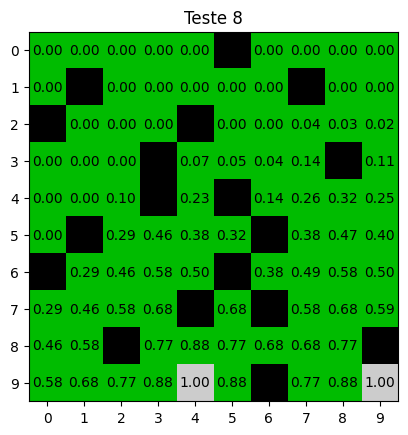

Iteração 8:
Valores de cada estado:
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.01]
 [0.   0.   0.   0.   0.   0.04 0.03 0.1  0.08 0.08]
 [0.   0.   0.07 0.   0.18 0.14 0.1  0.21 0.   0.2 ]
 [0.   0.07 0.23 0.   0.32 0.   0.21 0.32 0.4  0.33]
 [0.   0.   0.38 0.5  0.43 0.37 0.   0.42 0.5  0.43]
 [0.   0.38 0.5  0.59 0.52 0.   0.42 0.51 0.59 0.52]
 [0.38 0.5  0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.5  0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.1263857238540289



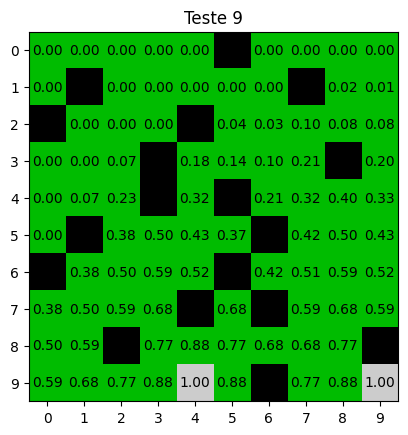

Iteração 9:
Valores de cada estado:
[[0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01]
 [0.   0.   0.   0.   0.   0.03 0.02 0.   0.06 0.06]
 [0.   0.   0.05 0.04 0.   0.1  0.08 0.17 0.14 0.16]
 [0.   0.05 0.18 0.   0.26 0.21 0.17 0.27 0.   0.27]
 [0.05 0.18 0.32 0.   0.37 0.   0.27 0.36 0.43 0.37]
 [0.04 0.   0.43 0.52 0.45 0.39 0.   0.44 0.52 0.45]
 [0.   0.43 0.52 0.59 0.52 0.   0.44 0.52 0.59 0.52]
 [0.43 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.10399739562845807



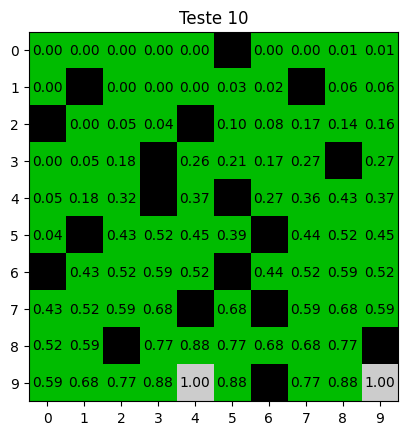

Iteração 10:
Valores de cada estado:
[[0.   0.   0.   0.   0.   0.   0.01 0.01 0.05 0.05]
 [0.   0.   0.04 0.03 0.02 0.08 0.06 0.   0.11 0.13]
 [0.   0.04 0.14 0.1  0.   0.17 0.14 0.22 0.19 0.23]
 [0.04 0.14 0.26 0.   0.31 0.26 0.22 0.31 0.   0.32]
 [0.14 0.26 0.37 0.   0.39 0.   0.31 0.38 0.45 0.39]
 [0.1  0.   0.45 0.52 0.46 0.4  0.   0.45 0.52 0.46]
 [0.   0.45 0.52 0.59 0.52 0.   0.45 0.52 0.59 0.52]
 [0.45 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.08423789045905106



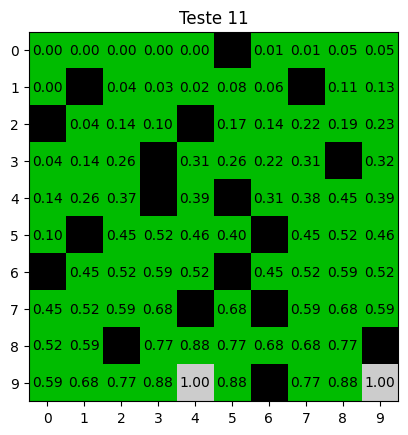

Iteração 11:
Valores de cada estado:
[[0.   0.   0.03 0.02 0.01 0.   0.05 0.04 0.09 0.1 ]
 [0.   0.   0.1  0.08 0.06 0.14 0.11 0.   0.15 0.18]
 [0.   0.1  0.21 0.17 0.   0.22 0.19 0.26 0.22 0.27]
 [0.1  0.21 0.31 0.   0.34 0.29 0.26 0.33 0.   0.34]
 [0.21 0.31 0.39 0.   0.4  0.   0.33 0.39 0.46 0.4 ]
 [0.17 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.0758141014131459



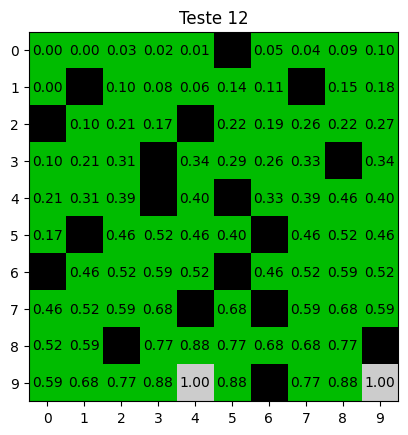

Iteração 12:
Valores de cada estado:
[[0.   0.02 0.08 0.06 0.05 0.   0.09 0.07 0.13 0.15]
 [0.   0.   0.17 0.14 0.11 0.18 0.15 0.   0.19 0.23]
 [0.   0.17 0.26 0.22 0.   0.25 0.22 0.29 0.25 0.29]
 [0.17 0.26 0.34 0.   0.35 0.3  0.29 0.34 0.   0.35]
 [0.26 0.34 0.4  0.   0.4  0.   0.34 0.4  0.46 0.4 ]
 [0.22 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.06671640924356843



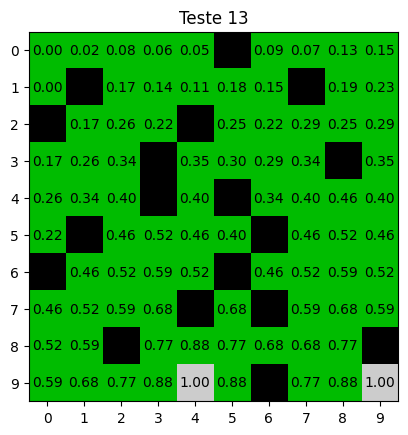

Iteração 13:
Valores de cada estado:
[[0.01 0.06 0.14 0.11 0.09 0.   0.13 0.1  0.16 0.19]
 [0.01 0.   0.22 0.18 0.15 0.21 0.19 0.   0.21 0.25]
 [0.   0.22 0.29 0.25 0.   0.26 0.25 0.3  0.26 0.3 ]
 [0.22 0.29 0.35 0.   0.35 0.31 0.3  0.35 0.   0.35]
 [0.29 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.25 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.057642977586443114



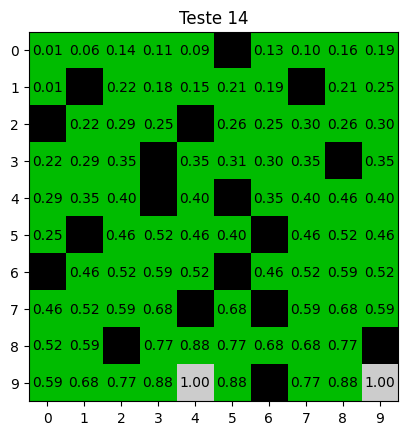

Iteração 14:
Valores de cada estado:
[[0.05 0.11 0.18 0.15 0.12 0.   0.16 0.13 0.18 0.22]
 [0.04 0.   0.25 0.21 0.18 0.23 0.21 0.   0.22 0.26]
 [0.   0.25 0.3  0.26 0.   0.27 0.26 0.31 0.27 0.31]
 [0.25 0.3  0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.3  0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.26 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.049048933655373425



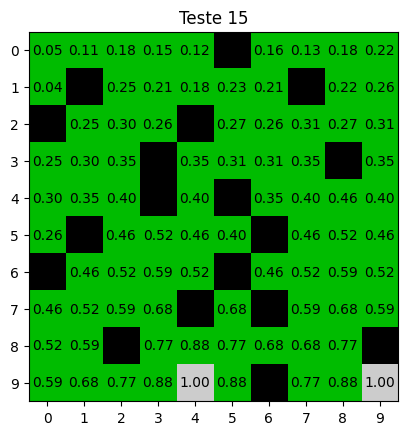

Iteração 15:
Valores de cada estado:
[[0.09 0.15 0.21 0.18 0.15 0.   0.18 0.15 0.19 0.23]
 [0.07 0.   0.26 0.23 0.2  0.23 0.22 0.   0.23 0.27]
 [0.   0.26 0.31 0.27 0.   0.27 0.27 0.31 0.27 0.31]
 [0.26 0.31 0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.31 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.27 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.04120110427051371



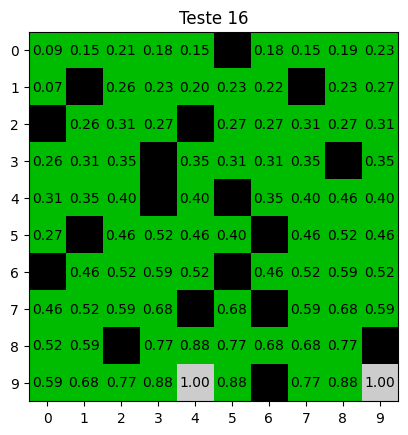

Iteração 16:
Valores de cada estado:
[[0.12 0.18 0.23 0.2  0.17 0.   0.19 0.17 0.2  0.23]
 [0.1  0.   0.27 0.23 0.2  0.24 0.23 0.   0.24 0.27]
 [0.   0.27 0.31 0.27 0.   0.27 0.27 0.31 0.27 0.31]
 [0.27 0.31 0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.31 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.27 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.03708099384346231



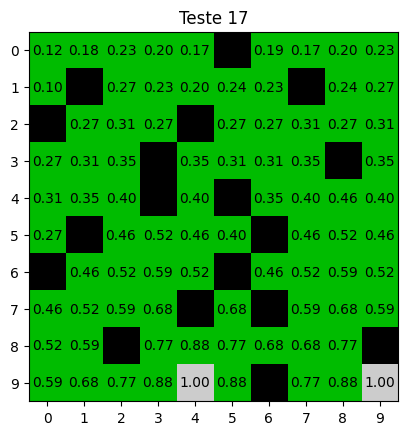

Iteração 17:
Valores de cada estado:
[[0.15 0.2  0.23 0.2  0.18 0.   0.2  0.18 0.21 0.24]
 [0.13 0.   0.27 0.24 0.21 0.24 0.24 0.   0.24 0.27]
 [0.   0.27 0.31 0.27 0.   0.27 0.27 0.31 0.27 0.31]
 [0.27 0.31 0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.31 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.27 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.02669831556729288



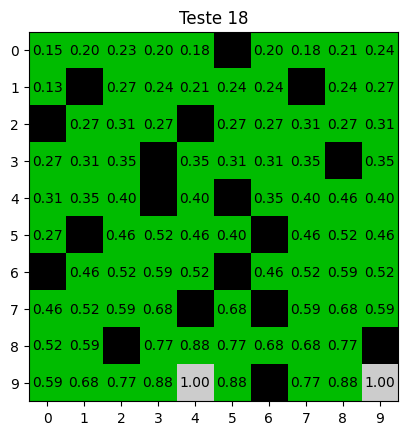

Iteração 18:
Valores de cada estado:
[[0.17 0.2  0.24 0.21 0.18 0.   0.21 0.18 0.21 0.24]
 [0.14 0.   0.27 0.24 0.21 0.24 0.24 0.   0.24 0.27]
 [0.   0.27 0.31 0.27 0.   0.27 0.27 0.31 0.27 0.31]
 [0.27 0.31 0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.31 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.27 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.0163393691271832



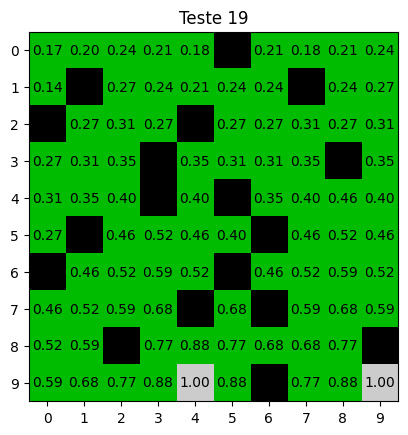

Iteração 19:
Valores de cada estado:
[[0.18 0.21 0.24 0.21 0.18 0.   0.21 0.18 0.21 0.24]
 [0.15 0.   0.27 0.24 0.21 0.24 0.24 0.   0.24 0.27]
 [0.   0.27 0.31 0.27 0.   0.27 0.27 0.31 0.27 0.31]
 [0.27 0.31 0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.31 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.27 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.009284783662794477



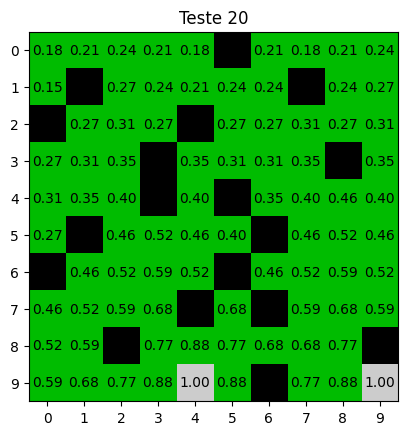

Iteração 20:
Valores de cada estado:
[[0.18 0.21 0.24 0.21 0.18 0.   0.21 0.18 0.21 0.24]
 [0.16 0.   0.27 0.24 0.21 0.24 0.24 0.   0.24 0.27]
 [0.   0.27 0.31 0.27 0.   0.27 0.27 0.31 0.27 0.31]
 [0.27 0.31 0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.31 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.27 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.004775031598008628



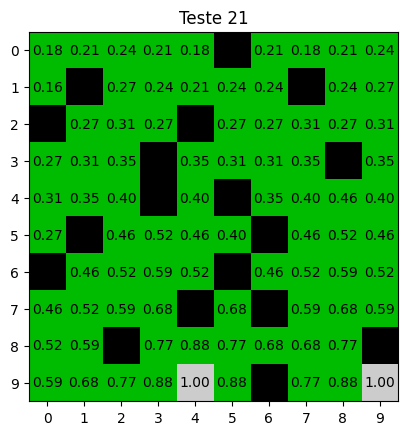

Iteração 21:
Valores de cada estado:
[[0.18 0.21 0.24 0.21 0.18 0.   0.21 0.18 0.21 0.24]
 [0.16 0.   0.27 0.24 0.21 0.24 0.24 0.   0.24 0.27]
 [0.   0.27 0.31 0.27 0.   0.27 0.27 0.31 0.27 0.31]
 [0.27 0.31 0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.31 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.27 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.002256202430059029



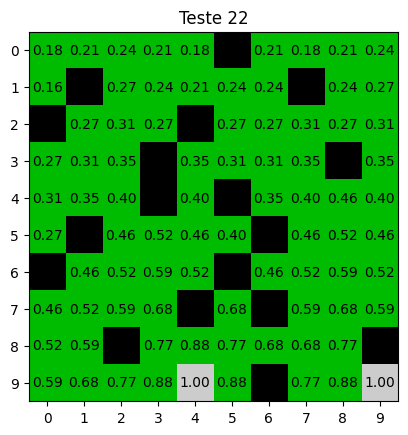

Iteração 22:
Valores de cada estado:
[[0.18 0.21 0.24 0.21 0.18 0.   0.21 0.18 0.21 0.24]
 [0.16 0.   0.27 0.24 0.21 0.24 0.24 0.   0.24 0.27]
 [0.   0.27 0.31 0.27 0.   0.27 0.27 0.31 0.27 0.31]
 [0.27 0.31 0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.31 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.27 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.0009927290692260116



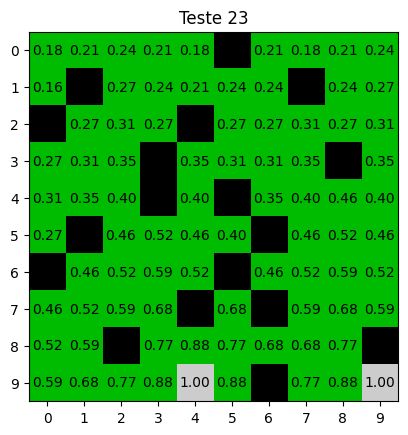

Iteração 23:
Valores de cada estado:
[[0.18 0.21 0.24 0.21 0.18 0.   0.21 0.18 0.21 0.24]
 [0.16 0.   0.27 0.24 0.21 0.24 0.24 0.   0.24 0.27]
 [0.   0.27 0.31 0.27 0.   0.27 0.27 0.31 0.27 0.31]
 [0.27 0.31 0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.31 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.27 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.0004109898346595364



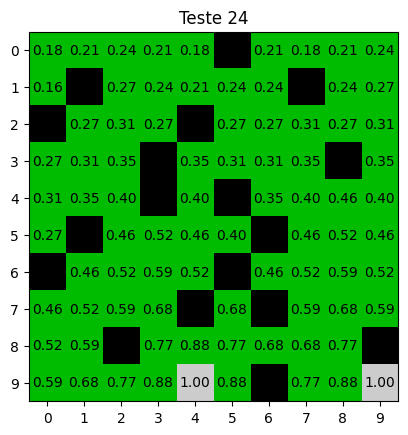

Iteração 24:
Valores de cada estado:
[[0.18 0.21 0.24 0.21 0.18 0.   0.21 0.18 0.21 0.24]
 [0.16 0.   0.27 0.24 0.21 0.24 0.24 0.   0.24 0.27]
 [0.   0.27 0.31 0.27 0.   0.27 0.27 0.31 0.27 0.31]
 [0.27 0.31 0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.31 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.27 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 0.00016140691688448783



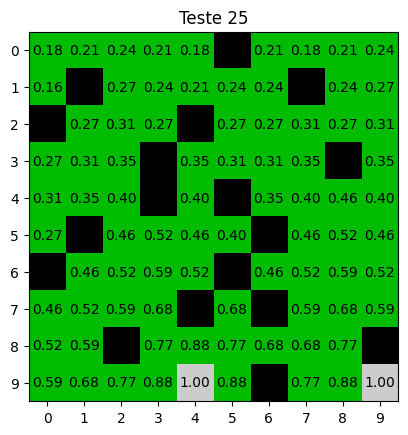

Iteração 25:
Valores de cada estado:
[[0.18 0.21 0.24 0.21 0.18 0.   0.21 0.18 0.21 0.24]
 [0.16 0.   0.27 0.24 0.21 0.24 0.24 0.   0.24 0.27]
 [0.   0.27 0.31 0.27 0.   0.27 0.27 0.31 0.27 0.31]
 [0.27 0.31 0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.31 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.27 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 6.0527593831627424e-05



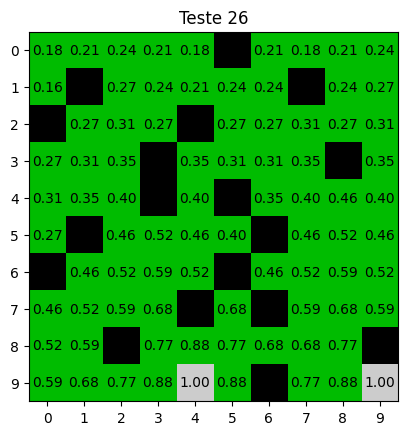

Iteração 26:
Valores de cada estado:
[[0.18 0.21 0.24 0.21 0.18 0.   0.21 0.18 0.21 0.24]
 [0.16 0.   0.27 0.24 0.21 0.24 0.24 0.   0.24 0.27]
 [0.   0.27 0.31 0.27 0.   0.27 0.27 0.31 0.27 0.31]
 [0.27 0.31 0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.31 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.27 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 2.1789933779409187e-05



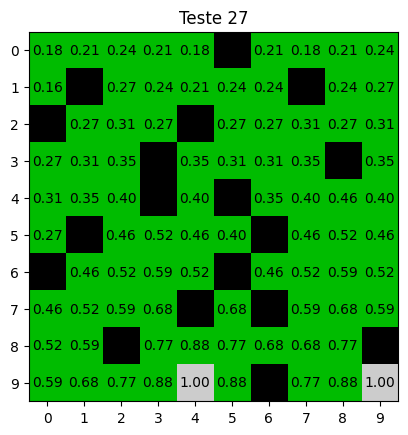

Iteração 27:
Valores de cada estado:
[[0.18 0.21 0.24 0.21 0.18 0.   0.21 0.18 0.21 0.24]
 [0.16 0.   0.27 0.24 0.21 0.24 0.24 0.   0.24 0.27]
 [0.   0.27 0.31 0.27 0.   0.27 0.27 0.31 0.27 0.31]
 [0.27 0.31 0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.31 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.27 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 7.564219869193867e-06



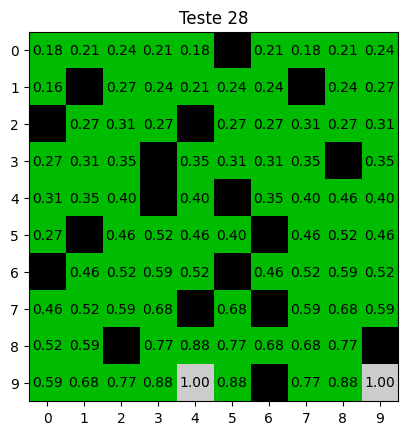

Iteração 28:
Valores de cada estado:
[[0.18 0.21 0.24 0.21 0.18 0.   0.21 0.18 0.21 0.24]
 [0.16 0.   0.27 0.24 0.21 0.24 0.24 0.   0.24 0.27]
 [0.   0.27 0.31 0.27 0.   0.27 0.27 0.31 0.27 0.31]
 [0.27 0.31 0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.31 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.27 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 2.5415778759918517e-06



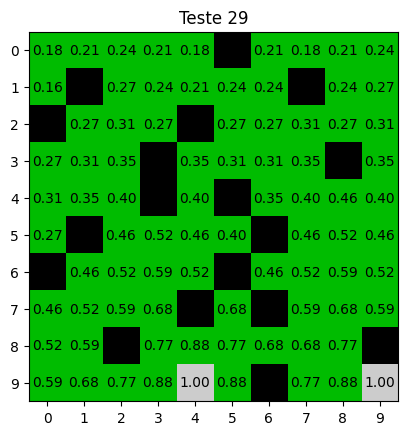

Iteração 29:
Valores de cada estado:
[[0.18 0.21 0.24 0.21 0.18 0.   0.21 0.18 0.21 0.24]
 [0.16 0.   0.27 0.24 0.21 0.24 0.24 0.   0.24 0.27]
 [0.   0.27 0.31 0.27 0.   0.27 0.27 0.31 0.27 0.31]
 [0.27 0.31 0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.31 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.27 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]
Delta (Maior diferença entre os valores): 8.291897820589256e-07



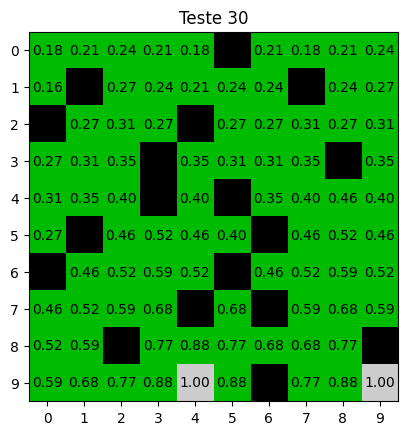

In [8]:
# Algoritmo de iteração de valor
iteration = 0  # Inicializa a contagem de iterações
while True:
    delta = 0  # Inicializa a maior mudança nos valores dos estados

    for row in range(num_rows):
        for col in range(num_cols):
            if env.grid[row, col] != -1:  # Ignora os obstáculos
                v = V[row, col]  # Obtém o valor atual do estado (linha, coluna)
                max_value = -float('inf')  # Inicializa o valor máximo como negativo infinito
                best_action = None  # Inicializa a melhor ação como nula

                for action in ['up', 'down', 'left', 'right']:
                    # Calcula o valor da ação para o estado atual usando a função calculate_value
                    action_value = calculate_value((row, col), action)
                    
                    if action_value > max_value:
                        max_value = action_value  # Atualiza o valor máximo encontrado
                        best_action = action  # Atualiza a melhor ação encontrada

                V[row, col] = max_value  # Define o valor do estado como o valor máximo encontrado
                delta = max(delta, abs(v - V[row, col]))  # Atualiza delta com a maior diferença entre os valores

    # Exibe informações da iteração atual
    print(f'Iteração {iteration}:')
    print(f'Valores de cada estado:')
    print(V.round(2))
    print(f'Delta (Maior diferença entre os valores): {delta}\n')
    
    # Plotar o mapa com os valores atuais
    plt.figure()
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.imshow(env.grid, cmap='nipy_spectral', interpolation='none')

    for row in range(num_rows):
        for col in range(num_cols):
            if env.grid[row, col] != -1:
                plt.text(col, row, f'{V[row, col]:.2f}', ha='center', va='center')  # Exibe os valores na grade

    plt.title(f'Teste {iteration + 1}')  # Define um título para o gráfico
    plt.show()  # Exibe o gráfico

    iteration += 1  # Incrementa o número de iterações

    if delta < 1e-6:  # Verifica se a maior mudança nos valores é menor que um limite
        break  # Se a condição for atendida, encerra a iteração

Valores finais:
[[0.18 0.21 0.24 0.21 0.18 0.   0.21 0.18 0.21 0.24]
 [0.16 0.   0.27 0.24 0.21 0.24 0.24 0.   0.24 0.27]
 [0.   0.27 0.31 0.27 0.   0.27 0.27 0.31 0.27 0.31]
 [0.27 0.31 0.35 0.   0.35 0.31 0.31 0.35 0.   0.35]
 [0.31 0.35 0.4  0.   0.4  0.   0.35 0.4  0.46 0.4 ]
 [0.27 0.   0.46 0.52 0.46 0.4  0.   0.46 0.52 0.46]
 [0.   0.46 0.52 0.59 0.52 0.   0.46 0.52 0.59 0.52]
 [0.46 0.52 0.59 0.68 0.   0.68 0.   0.59 0.68 0.59]
 [0.52 0.59 0.   0.77 0.88 0.77 0.68 0.68 0.77 0.  ]
 [0.59 0.68 0.77 0.88 1.   0.88 0.   0.77 0.88 1.  ]]


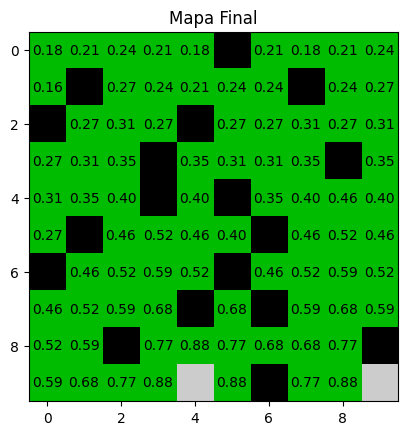

In [9]:
# Mostrar os valores finais de cada estado
print("Valores finais:")
print(V.round(2))  # Imprime os valores finais arredondados para 2 casas decimais

# Mostrar o mapa final com os valores
plt.figure()  # Cria uma nova figura para o gráfico
plt.imshow(env.grid, cmap='nipy_spectral', interpolation='none')  # Exibe a grade do ambiente com um mapa de cores
for row in range(num_rows):
    for col in range(num_cols):
        if env.grid[row, col] != 1:  # Ignora os pontos de entrega (objetivos)
            plt.text(col, row, f'{V[row, col]:.2f}', ha='center', va='center')  # Exibe os valores na grade
plt.title('Mapa Final')  # Define um título para o gráfico
plt.show()  # Exibe o gráfico

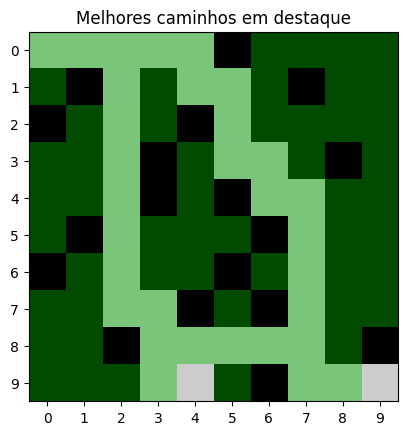

In [10]:
# Melhores caminhos armazenado em uma lista de coordenadas (path)
path1 = [(0,0),(0,1),(0,2),(1,2),(2,2),(3,2),(4,2),(5,2),(6,2),(7,2),(7,3),(8,3),(9,3),(9,4)]
path2 = [(0,0),(0,1),(0,2),(1,2),(2,2),(3,2),(4,2),(5,2),(6,2),(7,2),(7,3),(8,3),(8,4),(8,5),(8,6),(8,7),(9,7),(9,8),(9,9)]
path3 = [(0,0),(0,1),(0,2),(0,3),(0,4),(1,4),(1,5),(2,5),(3,5),(3,6),(4,6),(4,7),(5,7),(6,7),(7,7),(8,7),(9,7),(9,8),(9,9)]

# Cria uma matriz de destaque para destacar os estados nos caminhos
highlight = np.zeros_like(env.grid)

# Marca os estados nos caminhos como destacados (1)
for state in path1:
    highlight[state[0], state[1]] = 1

for state in path2:
    highlight[state[0], state[1]] = 1

for state in path3:
    highlight[state[0], state[1]] = 1

# Define uma paleta de cores para destacar os caminhos
cmap = plt.get_cmap('nipy_spectral')
cmap.set_bad('gray')  # Define a cor para estados não destacados como cinza

# Plota o ambiente e os caminhos destacados
plt.figure()  # Cria uma nova figura para o gráfico
plt.imshow(env.grid, cmap=cmap, interpolation='none')  # Exibe a grade do ambiente com a paleta de cores
plt.imshow(highlight, cmap=cmap, interpolation='none', alpha=0.6)  # Use alpha para tornar as linhas dos caminhos transparentes

plt.xticks(range(10))
plt.yticks(range(10))
plt.title('Melhores caminhos em destaque')  # Define um título para o gráfico
plt.show()  # Exibe o gráfico

#### Neste código modelamos um `MDP`, especificando:

* `(S)` - O conjunto de estados
* `(A)` - O conjunto de ações
* `(R)` - A função de recompensa
* `(T)` - A função de transição (que descreve a probabilidade de transição de um estado para o outro após uma ação)


## 3 - Implementação da Q-Table

  * Crie uma Q-Table para representar o valor estimado de cada par (estado, ação).

In [11]:
class QTable:
    def __init__(self, environment):
        # Inicializa a classe com um ambiente específico
        self.env = environment  # Armazena uma referência ao ambiente
        num_states = len(environment.get_states())  # Obtém o número de estados no ambiente
        num_actions = len(environment.get_actions())  # Obtém o número de ações possíveis no ambiente
        self.q_table = np.zeros((num_states, num_actions))  # Inicializa a tabela Q com zeros

    def get_q_value(self, state, action):
        # Obtém o valor Q associado a um estado e a uma ação específica
        state_idx = self.env.get_states().index(state)  # Encontra o índice do estado na lista de estados
        action_idx = self.env.get_actions().index(action)  # Encontra o índice da ação na lista de ações
        return self.q_table[state_idx, action_idx]  # Retorna o valor Q correspondente

    def set_q_value(self, state, action, value):
        # Define o valor Q associado a um estado e a uma ação específica
        state_idx = self.env.get_states().index(state)  # Encontra o índice do estado na lista de estados
        action_idx = self.env.get_actions().index(action)  # Encontra o índice da ação na lista de ações
        self.q_table[state_idx, action_idx] = value  # Define o valor Q correspondente como o valor fornecido

In [12]:
# Crie a Q-Table
q_table = QTable(env)
q_table

#### Considerações
 
* Criamos uma Q-Table inicializada com zeros. Cada linha representa um estado e cada coluna uma ação.
* O agente irá atualizar os valores nessa tabela durante o treinamento usando o algoritmo de aprendizado por reforço.

## 4 - Implementação do agente

  * Desenvolva um agente de aprendizado por reforço que utiliza a equação de Bellman para atualizar a Q-Table com

In [13]:
class QLearningAgent:
    def __init__(self, environment, learning_rate=0.1, discount_factor=0.9, exploration_prob=0.2):
        # Inicializa a classe com um ambiente específico e parâmetros de aprendizado
        self.env = environment  # Armazena uma referência ao ambiente
        self.learning_rate = learning_rate  # Taxa de aprendizado (alpha)
        self.discount_factor = discount_factor  # Fator de desconto (gamma)
        self.exploration_prob = exploration_prob  # Probabilidade de exploração (epsilon)
        self.q_table = self.create_q_table()  # Cria a tabela Q

    def create_q_table(self):
        # Cria a tabela Q inicializada com zeros
        num_states = len(self.env.get_states())  # Obtém o número de estados no ambiente
        num_actions = len(self.env.get_actions())  # Obtém o número de ações possíveis no ambiente
        return np.zeros((num_states, num_actions))

    def select_action(self, state):
        # Seleciona uma ação com base na estratégia de exploração
        if random.uniform(0, 1) < self.exploration_prob:
            # Escolha uma ação aleatória com probabilidade de exploração
            return random.choice(self.env.get_actions())
        else:
            # Escolha a ação com o maior valor na Q-Table
            state_idx = self.env.get_states().index(state)
            q_values = self.q_table[state_idx, :]
            return self.env.get_actions()[np.argmax(q_values)]

    def update_q_table(self, state, action, reward, next_state):
        # Atualiza a tabela Q com base na regra do Q-Learning
        state_idx = self.env.get_states().index(state)
        action_idx = self.env.get_actions().index(action)
        next_state_idx = self.env.get_states().index(next_state)

        current_q_value = self.q_table[state_idx, action_idx]
        max_next_q_value = np.max(self.q_table[next_state_idx, :])

        new_q_value = (1 - self.learning_rate) * current_q_value + self.learning_rate * (reward + self.discount_factor * max_next_q_value)
        self.q_table[state_idx, action_idx] = new_q_value

    def train(self, max_episodes, max_steps_per_episode, convergence_threshold=0.01):
        # Treina o agente através de episódios
        for episode in range(max_episodes):
            state = self.env.get_state()
            total_reward = 0
            delta = 0  # Para rastrear a maior mudança nos valores Q

            for step in range(max_steps_per_episode):
                action = self.select_action(state)
                next_state, reward = self.take_action_and_get_next_state(state, action)
                total_reward += reward
                self.update_q_table(state, action, reward, next_state)

                # Atualize o delta com a mudança nos valores Q
                state_idx = self.env.get_states().index(state)
                action_idx = self.env.get_actions().index(action)
                delta = max(delta, abs(reward + self.discount_factor * np.max(self.q_table[state_idx, :]) - self.q_table[state_idx, action_idx]))

                state = next_state

                if self.env.is_done() or delta < convergence_threshold:
                    break

            print(f"Episode {episode + 1}: Total Reward = {total_reward}")

            if episode >= max_episodes - 1:
                break

    def take_action_and_get_next_state(self, state, action):
        # Realiza uma ação no ambiente e obtém o próximo estado e a recompensa resultante
        self.env.take_action(action)
        next_state = self.env.get_state()
        reward = self.env.get_reward()
        return next_state, reward

In [14]:
# Criar um agente Q-Learning
agent = QLearningAgent(env, learning_rate=0.1, discount_factor=0.9, exploration_prob=0.2)
agent

In [15]:
# Treine o agente por um número de episódios
num_episodes = 1000
agent.train(num_episodes, max_steps_per_episode=100, convergence_threshold=0.01)

Episode 1: Total Reward = -100
Episode 2: Total Reward = -100
Episode 3: Total Reward = -100
Episode 4: Total Reward = -100
Episode 5: Total Reward = -100
Episode 6: Total Reward = -100
Episode 7: Total Reward = 593
Episode 8: Total Reward = 857
Episode 9: Total Reward = 406
Episode 10: Total Reward = 76
Episode 11: Total Reward = 384
Episode 12: Total Reward = 978
Episode 13: Total Reward = 978
Episode 14: Total Reward = 912
Episode 15: Total Reward = 934
Episode 16: Total Reward = 890
Episode 17: Total Reward = 956
Episode 18: Total Reward = 945
Episode 19: Total Reward = 967
Episode 20: Total Reward = 10
Episode 21: Total Reward = 890
Episode 22: Total Reward = 10
Episode 23: Total Reward = 10
Episode 24: Total Reward = 10
Episode 25: Total Reward = 890
Episode 26: Total Reward = 10
Episode 27: Total Reward = 10
Episode 28: Total Reward = 10
Episode 29: Total Reward = 10
Episode 30: Total Reward = 10
Episode 31: Total Reward = 10
Episode 32: Total Reward = 10
Episode 33: Total Rewar

In [16]:
# Função para testar o agente
def test_agent(agent, max_steps=100):
    state = agent.env.get_state()  # Obtém o estado inicial do ambiente
    total_reward = 0  # Inicializa a recompensa total acumulada

    for step in range(max_steps):
        action = agent.select_action(state)  # Seleciona a próxima ação com base na tabela Q aprendida
        next_state, reward = agent.take_action_and_get_next_state(state, action)  # Realiza a ação e obtém o próximo estado e recompensa
        total_reward += reward  # Acumula a recompensa total
        state = next_state  # Atualiza o estado para o próximo estado

        agent.env.print_environment()  # Mostra o ambiente após cada ação

        if agent.env.is_done():  # Verifica se o ambiente está concluído
            break

    return total_reward  # Retorna a recompensa total acumulada após a interação com o ambiente


In [17]:
# Criando um agente Q-Learning e treinando
agent = QLearningAgent(env, learning_rate=0.1, discount_factor=0.9, exploration_prob=0.2)
agent.create_q_table()
agent.train(max_episodes=1000, max_steps_per_episode=100, convergence_threshold=0.01)

Episode 1: Total Reward = -45
Episode 2: Total Reward = 43
Episode 3: Total Reward = 615
Episode 4: Total Reward = 549
Episode 5: Total Reward = -100
Episode 6: Total Reward = -100
Episode 7: Total Reward = -100
Episode 8: Total Reward = 637
Episode 9: Total Reward = 923
Episode 10: Total Reward = 516
Episode 11: Total Reward = 472
Episode 12: Total Reward = 406
Episode 13: Total Reward = 362
Episode 14: Total Reward = 384
Episode 15: Total Reward = 351
Episode 16: Total Reward = 395
Episode 17: Total Reward = 285
Episode 18: Total Reward = 923
Episode 19: Total Reward = 901
Episode 20: Total Reward = 923
Episode 21: Total Reward = 945
Episode 22: Total Reward = 956
Episode 23: Total Reward = 956
Episode 24: Total Reward = 10
Episode 25: Total Reward = 10
Episode 26: Total Reward = 10
Episode 27: Total Reward = 10
Episode 28: Total Reward = 10
Episode 29: Total Reward = 10
Episode 30: Total Reward = 10
Episode 31: Total Reward = 10
Episode 32: Total Reward = 10
Episode 33: Total Reward

In [18]:
# Teste o agente
total_reward = test_agent(agent, max_steps=100)

-- -- -- -- -- X -- -- -- -- 
-- X -- -- -- -- -- X -- -- 
X -- -- -- X -- -- -- -- -- 
-- -- -- X -- -- -- -- X -- 
-- -- -- X -- X -- -- -- -- 
-- X -- -- -- -- X -- -- -- 
X -- -- -- -- X -- -- -- -- 
-- -- -- -- X -- X -- -- -- 
-- -- X -- -- -- -- -- -- X 
-- -- -- -- A -- X -- -- D 
-- -- -- -- -- X -- -- -- -- 
-- X -- -- -- -- -- X -- -- 
X -- -- -- X -- -- -- -- -- 
-- -- -- X -- -- -- -- X -- 
-- -- -- X -- X -- -- -- -- 
-- X -- -- -- -- X -- -- -- 
X -- -- -- -- X -- -- -- -- 
-- -- -- -- X -- X -- -- -- 
-- -- X -- -- -- -- -- -- X 
-- -- -- -- A -- X -- -- D 
-- -- -- -- -- X -- -- -- -- 
-- X -- -- -- -- -- X -- -- 
X -- -- -- X -- -- -- -- -- 
-- -- -- X -- -- -- -- X -- 
-- -- -- X -- X -- -- -- -- 
-- X -- -- -- -- X -- -- -- 
X -- -- -- -- X -- -- -- -- 
-- -- -- -- X -- X -- -- -- 
-- -- X -- -- -- -- -- -- X 
-- -- -- -- A -- X -- -- D 
-- -- -- -- -- X -- -- -- -- 
-- X -- -- -- -- -- X -- -- 
X -- -- -- X -- -- -- -- -- 
-- -- -- X -- -- -- -- X -- 
-- -- -- X --

In [19]:
# Verificando a pontuação final
print(f"Total Reward: {total_reward}")

Total Reward: 890


#### No código acima concluímos os passos:
* Definição das regras 
    * learning_rate
    * discount_factor
    * exploration_prob (ε-greedy)
* Treinamos o agente
* Atualização dos valores da Q-Table

## 5 - Living Penalty

  * Introduza um "living penalty" para penalizar o agente por gastar muito tempo no ambiente. Isso deve incentivar o agente a encontrar a rota mais eficiente para entregar os pacotes.

In [20]:
"""
A definição de Living Penalty foi implementada no script 1 (class Environment)
Então aqui irei apenas rodar o ambiente.
"""

'\nA definição de Living Penalty foi implementada no script 1 (class Environment)\nEntão aqui irei apenas rodar o ambiente.\n'

In [21]:
# Exemplo de uso:
grid_size = (10, 10)
obstacles = [(0,5), (1,1), (1,7), (2,4), (2,0), (3,8), (3,3), (4,3), (4,5), (5,1), (5,6), (6,0), (6,5), (7,4), (7,6), (8,2), (8,9), (9,6)]
delivery_points = [(9,4), (9,9)]

In [22]:
# Em algum lugar do código onde você cria o ambiente
env = Environment(grid_size, obstacles, delivery_points)
env.time_penalty = 0.1  # Defina o valor da penalização de tempo

In [23]:
env.reset()
env.print_environment()

A -- -- -- -- X -- -- -- -- 
-- X -- -- -- -- -- X -- -- 
X -- -- -- X -- -- -- -- -- 
-- -- -- X -- -- -- -- X -- 
-- -- -- X -- X -- -- -- -- 
-- X -- -- -- -- X -- -- -- 
X -- -- -- -- X -- -- -- -- 
-- -- -- -- X -- X -- -- -- 
-- -- X -- -- -- -- -- -- X 
-- -- -- -- D -- X -- -- D 


## 6 - Treinamento e avaliação

  * Treine o agente usando um algoritmo de aprendizado por reforço, como o Q-Learning, e avalie seu desempenho em termos de eficiência na entrega de pacotes.

In [24]:
class TimePenalty:
    def __init__(self, penalty_value=0.1):
        # Inicializa a classe com um valor de penalização de tempo (opcional)
        self.penalty_value = penalty_value  # Armazena o valor da penalização

    def apply_penalty(self, reward):
        # Aplica a penalização de tempo a uma recompensa
        return reward - self.penalty_value  # Subtrai o valor da penalização da recompensa original

In [25]:
class QLearningAgent:
    def __init__(self, environment, learning_rate=0.1, discount_factor=0.9, exploration_prob=0.2):
        # Inicializa a classe com um ambiente específico e parâmetros de aprendizado
        self.env = environment  # Armazena uma referência ao ambiente
        self.learning_rate = learning_rate  # Taxa de aprendizado (alpha)
        self.discount_factor = discount_factor  # Fator de desconto (gamma)
        self.exploration_prob = exploration_prob  # Probabilidade de exploração (epsilon)
        self.q_table = self.create_q_table()  # Cria a tabela Q

    def create_q_table(self):
        # Cria a tabela Q inicializada com zeros
        num_states = len(self.env.get_states())  # Obtém o número de estados no ambiente
        num_actions = len(self.env.get_actions())  # Obtém o número de ações possíveis no ambiente
        return np.zeros((num_states, num_actions))

    def select_action(self, state):
        # Seleciona uma ação com base na estratégia de exploração
        if random.uniform(0, 1) < self.exploration_prob:
            # Escolha uma ação aleatória com probabilidade de exploração
            return random.choice(self.env.get_actions())
        else:
            # Escolha a ação com o maior valor na Q-Table
            state_idx = self.env.get_states().index(state)
            q_values = self.q_table[state_idx, :]
            return self.env.get_actions()[np.argmax(q_values)]

    def update_q_table(self, state, action, reward, next_state):
        # Atualiza a tabela Q com base na regra do Q-Learning
        state_idx = self.env.get_states().index(state)
        action_idx = self.env.get_actions().index(action)
        next_state_idx = self.env.get_states().index(next_state)

        current_q_value = self.q_table[state_idx, action_idx]
        max_next_q_value = np.max(self.q_table[next_state_idx, :])

        new_q_value = (1 - self.learning_rate) * current_q_value + self.learning_rate * (reward + self.discount_factor * max_next_q_value)
        self.q_table[state_idx, action_idx] = new_q_value

    def train(self, max_episodes, max_steps_per_episode, convergence_threshold=0.01):
        # Treina o agente através de episódios
        for episode in range(max_episodes):
            state = self.env.get_state()
            total_reward = 0
            delta = 0  # Para rastrear a maior mudança nos valores Q

            for step in range(max_steps_per_episode):
                action = self.select_action(state)
                next_state, reward = self.take_action_and_get_next_state(state, action)
                total_reward += reward
                self.update_q_table(state, action, reward, next_state)

                # Atualize o delta com a mudança nos valores Q
                state_idx = self.env.get_states().index(state)
                action_idx = self.env.get_actions().index(action)
                delta = max(delta, abs(reward + self.discount_factor * np.max(self.q_table[state_idx, :]) - self.q_table[state_idx, action_idx]))

                state = next_state

                if self.env.is_done() or delta < convergence_threshold:
                    break

            print(f"Episode {episode + 1}: Total Reward = {total_reward}")

            if episode >= max_episodes - 1:
                break

    def take_action_and_get_next_state(self, state, action):
        # Realiza uma ação no ambiente e obtém o próximo estado e a recompensa resultante
        self.env.take_action(action)
        next_state = self.env.get_state()
        reward = self.env.get_reward()
        return next_state, reward

In [26]:
class Environment:
    def __init__(self, grid_size, obstacles, delivery_points):
        # Inicializa o ambiente com o tamanho da grade, obstáculos e pontos de entrega
        self.grid_size = grid_size  # Tamanho da grade (número de linhas e colunas)
        self.grid = np.zeros(grid_size, dtype=int)  # Cria uma grade preenchida com zeros
        self.obstacles = obstacles  # Lista de coordenadas de obstáculos
        self.delivery_points = delivery_points  # Lista de coordenadas de pontos de entrega
        self.agent_position = (0, 0)  # Define a posição inicial do agente
        self.done = False  # Flag que indica se o ambiente está concluído

    def reset(self):
        # Reinicializa o ambiente
        self.grid = np.zeros(self.grid_size, dtype=int)  # Zera a grade
        self.agent_position = (0, 0)  # Define a posição inicial

        for obs in self.obstacles:
            self.grid[obs] = -1  # Marca os obstáculos na grade com -1

        for delivery_point in self.delivery_points:
            self.grid[delivery_point] = 1  # Marca os pontos de entrega na grade com 1

    def is_valid_move(self, position):
        # Verifica se um movimento é válido (dentro dos limites da grade e não é um obstáculo)
        x, y = position
        return 0 <= x < self.grid_size[0] and 0 <= y < self.grid_size[1] and self.grid[position] != -1

    def take_action(self, action):
        # Executa uma ação no ambiente
        if action == 'up':
            new_position = (self.agent_position[0] - 1, self.agent_position[1])
        elif action == 'down':
            new_position = (self.agent_position[0] + 1, self.agent_position[1])
        elif action == 'left':
            new_position = (self.agent_position[0], self.agent_position[1] - 1)
        elif action == 'right':
            new_position = (self.agent_position[0], self.agent_position[1] + 1)
        else:
            raise ValueError("Ação inválida")  # Levanta uma exceção para ação inválida

        if self.is_valid_move(new_position):
            self.agent_position = new_position  # Atualiza a posição do agente

        if self.agent_position == self.delivery_points:
            self.done = True  # Se o agente atingir um ponto de entrega, o ambiente é considerado concluído

    def get_states(self):
        # Obtém todos os estados possíveis no ambiente
        states = []
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                states.append((i, j))
        return states

    def get_actions(self):
        # Obtém a lista de ações possíveis
        return ['up', 'down', 'left', 'right']

    def get_state(self):
        # Obtém a posição atual do agente (estado atual)
        return self.agent_position

    def is_at_delivery_point(self):
        # Verifica se o agente está em um ponto de entrega
        return self.grid[self.agent_position] == 1

    def get_reward(self):
        # Calcula a recompensa com base na posição do agente
        if self.is_at_delivery_point():
            return 10  # Recompensa positiva por entregar um pacote
        else:
            return -1  # Penalização (living penalty) por cada passo

    def is_done(self):
        # Verifica se o ambiente está concluído (todos os pontos de entrega foram visitados)
        return all([self.grid[position] == 0 for position in self.delivery_points])

    def print_environment(self):
        # Imprime o ambiente (grade) com indicadores para agente, obstáculos e pontos de entrega
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if (i, j) == self.agent_position:
                    print("A", end=' ')  # Agente
                elif self.grid[i, j] == -1:
                    print("X", end=' ')  # Obstáculo
                elif self.grid[i, j] == 1:
                    print("D", end=' ')  # Ponto de entrega
                else:
                    print("--", end=' ')  # Espaço vazio
            print()  # Nova linha para a próxima linha da grade

In [27]:
# Crie o ambiente com penalização por tempo
grid_size = (10, 10)
obstacles = [(0, 5), (1, 1), (1, 7), (2, 4), (2, 0), (3, 8), (3, 3), (4, 3), (4, 5), (5, 1), (5, 6), (6, 0), (6, 5), (7, 4), (7, 6), (8, 2), (8, 9), (9, 6)]
delivery_points = [(9, 4), (9, 9)]
env = Environment(grid_size, obstacles, delivery_points)
env.time_penalty = 0.1  # Defina o valor da penalização de tempo

In [28]:
# Inicialização do ambiente
env.reset()
env.print_environment()

A -- -- -- -- X -- -- -- -- 
-- X -- -- -- -- -- X -- -- 
X -- -- -- X -- -- -- -- -- 
-- -- -- X -- -- -- -- X -- 
-- -- -- X -- X -- -- -- -- 
-- X -- -- -- -- X -- -- -- 
X -- -- -- -- X -- -- -- -- 
-- -- -- -- X -- X -- -- -- 
-- -- X -- -- -- -- -- -- X 
-- -- -- -- D -- X -- -- D 


In [29]:
# Crie um agente Q-Learning e treine-o
agent = QLearningAgent(env, learning_rate=0.1, discount_factor=0.9, exploration_prob=0.2)
agent.create_q_table()
agent.train(max_episodes=1000, max_steps_per_episode=100, convergence_threshold=0.01)

Episode 1: Total Reward = -100
Episode 2: Total Reward = -100
Episode 3: Total Reward = -100
Episode 4: Total Reward = -100
Episode 5: Total Reward = -100
Episode 6: Total Reward = 296
Episode 7: Total Reward = 670
Episode 8: Total Reward = 747
Episode 9: Total Reward = 813
Episode 10: Total Reward = 813
Episode 11: Total Reward = 835
Episode 12: Total Reward = 857
Episode 13: Total Reward = 901
Episode 14: Total Reward = 780
Episode 15: Total Reward = 791
Episode 16: Total Reward = 32
Episode 17: Total Reward = 648
Episode 18: Total Reward = 857
Episode 19: Total Reward = 10
Episode 20: Total Reward = 10
Episode 21: Total Reward = 10
Episode 22: Total Reward = 10
Episode 23: Total Reward = 747
Episode 24: Total Reward = 769
Episode 25: Total Reward = 10
Episode 26: Total Reward = 879
Episode 27: Total Reward = 10
Episode 28: Total Reward = 10
Episode 29: Total Reward = 846
Episode 30: Total Reward = 10
Episode 31: Total Reward = 10
Episode 32: Total Reward = 879
Episode 33: Total Rewa

In [30]:
def test_agent(agent, max_steps=100):
    # Testa o agente no ambiente
    state = agent.env.get_state()  # Obtém o estado inicial
    total_reward = 0  # Inicializa a recompensa total acumulada

    for step in range(max_steps):
        action = agent.select_action(state)  # Seleciona uma ação com base na política do agente
        next_state, reward = agent.take_action_and_get_next_state(state, action)  # Executa a ação no ambiente e obtém o próximo estado e recompensa
        total_reward += reward  # Acumula a recompensa total com a recompensa obtida
        state = next_state  # Atualiza o estado atual para o próximo estado

        agent.env.print_environment()  # Imprime a representação visual do ambiente após cada ação

        if agent.env.is_done():
            break  # Se o ambiente estiver concluído (todos os pontos de entrega foram visitados), encerra o teste

    return total_reward  # Retorna a recompensa total acumulada durante o teste

In [31]:
# Verificar passos do agente
total_reward = test_agent(agent, max_steps=100)

-- -- -- -- -- X -- -- -- -- 
-- X -- -- -- -- -- X -- -- 
X -- -- -- X -- -- -- -- -- 
-- -- -- X -- -- -- -- X -- 
-- -- -- X -- X -- -- -- -- 
-- X -- -- -- -- X -- -- -- 
X -- -- -- -- X -- -- -- -- 
-- -- -- -- X -- X -- -- -- 
-- -- X -- -- -- -- -- -- X 
-- -- -- -- D A X -- -- D 
-- -- -- -- -- X -- -- -- -- 
-- X -- -- -- -- -- X -- -- 
X -- -- -- X -- -- -- -- -- 
-- -- -- X -- -- -- -- X -- 
-- -- -- X -- X -- -- -- -- 
-- X -- -- -- -- X -- -- -- 
X -- -- -- -- X -- -- -- -- 
-- -- -- -- X -- X -- -- -- 
-- -- X -- -- -- -- -- -- X 
-- -- -- -- A -- X -- -- D 
-- -- -- -- -- X -- -- -- -- 
-- X -- -- -- -- -- X -- -- 
X -- -- -- X -- -- -- -- -- 
-- -- -- X -- -- -- -- X -- 
-- -- -- X -- X -- -- -- -- 
-- X -- -- -- -- X -- -- -- 
X -- -- -- -- X -- -- -- -- 
-- -- -- -- X -- X -- -- -- 
-- -- X -- -- -- -- -- -- X 
-- -- -- -- A -- X -- -- D 
-- -- -- -- -- X -- -- -- -- 
-- X -- -- -- -- -- X -- -- 
X -- -- -- X -- -- -- -- -- 
-- -- -- X -- -- -- -- X -- 
-- -- -- X -- 

In [32]:
# Verificar pontuação total final
print(f"Total Reward: {total_reward}")

Total Reward: 824
